In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
dogecoin = pd.read_csv('/content/DOGE-USD.csv')
dogecoin.head()

,Date,Open,High,Low,Close,Volume
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,6259550
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,4246520
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,2231080
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,3288960
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,2481270


In [3]:
dogecoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532 entries, 0 to 1531
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1532 non-null   object 
 1   Open    1532 non-null   float64
 2   High    1532 non-null   float64
 3   Low     1532 non-null   float64
 4   Close   1532 non-null   float64
 5   Volume  1532 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.9+ KB


In [4]:
dogecoin[dogecoin.isnull().any(axis=1)]

,Date,Open,High,Low,Close,Volume


In [5]:
dogecoin = dogecoin.dropna()
dogecoin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1532 entries, 0 to 1531
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1532 non-null   object 
 1   Open    1532 non-null   float64
 2   High    1532 non-null   float64
 3   Low     1532 non-null   float64
 4   Close   1532 non-null   float64
 5   Volume  1532 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 83.8+ KB


### Univariate Analysis

In [6]:
# We'll take only one variable into consideration to Predict the Price of the DOGECOIN
close = dogecoin.Close.iloc[:].to_numpy()
close

array([0.001415, 0.001163, 0.001201, ..., 0.177176, 0.171145, 0.166144])

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
closeScaled = scaler.fit_transform(np.array(close).reshape(-1,1))
closeScaled

array([[5.51379986e-04],
       [1.82818298e-04],
       [2.38395060e-04],
       ...,
       [2.57609994e-01],
       [2.48789377e-01],
       [2.41475183e-01]])

In [8]:
# Let's split the data into test and train
closeLength = len(closeScaled)
train, test = closeScaled[:(closeLength-150)], closeScaled[(closeLength-150):]
len(train), len(test)

(1382, 150)

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# define generator
inputs = 15
features = 1 ## Univariate means only 1 independent variable
generator = TimeseriesGenerator(train, train, length=inputs, batch_size=1)

In [10]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(inputs, features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(generator, epochs=100)

Epoch 1/100
1367/1367 [==============================] - 16s 10ms/step - loss: 0.0028
Epoch 2/100
1367/1367 [==============================] - 14s 11ms/step - loss: 0.0011
Epoch 3/100
1367/1367 [==============================] - 16s 11ms/step - loss: 0.0010
Epoch 4/100
1367/1367 [==============================] - 14s 10ms/step - loss: 0.0010
Epoch 5/100
1367/1367 [==============================] - 14s 10ms/step - loss: 7.3270e-04
Epoch 6/100
1367/1367 [==============================] - 15s 11ms/step - loss: 6.4945e-04
Epoch 7/100
1367/1367 [==============================] - 14s 11ms/step - loss: 5.6471e-04
Epoch 8/100
1367/1367 [==============================] - 14s 10ms/step - loss: 5.6508e-04
Epoch 9/100
1367/1367 [==============================] - 14s 10ms/step - loss: 5.3058e-04
Epoch 10/100
1367/1367 [==============================] - 15s 11ms/step - loss: 4.9069e-04
Epoch 11/100
1367/1367 [==============================] - 14s 10ms/step - loss: 5.1115e-04
Epoch 12/100
1367/1367 [

In [13]:
test_predictions = []

first_eval_batch = train[-inputs:]
current_batch = first_eval_batch.reshape((1, inputs, features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [14]:
test_predictions

[array([0.47403336], dtype=float32),
 array([0.48175815], dtype=float32),
 array([0.48637646], dtype=float32),
 array([0.48934495], dtype=float32),
 array([0.4915448], dtype=float32),
 array([0.49251863], dtype=float32),
 array([0.49525893], dtype=float32),
 array([0.49691078], dtype=float32),
 array([0.50028384], dtype=float32),
 array([0.5030338], dtype=float32),
 array([0.5051314], dtype=float32),
 array([0.507734], dtype=float32),
 array([0.5100908], dtype=float32),
 array([0.5123538], dtype=float32),
 array([0.51375324], dtype=float32),
 array([0.515399], dtype=float32),
 array([0.51701087], dtype=float32),
 array([0.5185375], dtype=float32),
 array([0.51998615], dtype=float32),
 array([0.5214114], dtype=float32),
 array([0.52267796], dtype=float32),
 array([0.5238766], dtype=float32),
 array([0.5249084], dtype=float32),
 array([0.5258149], dtype=float32),
 array([0.5266131], dtype=float32),
 array([0.52722985], dtype=float32),
 array([0.5277387], dtype=float32),
 array([0.5281194

In [16]:
true_predictions = scaler.inverse_transform(test_predictions)

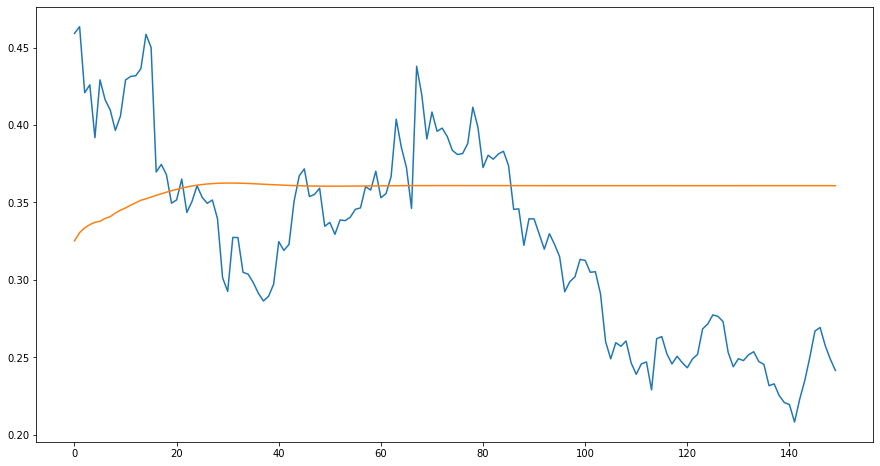

In [17]:
plt.figure(figsize=(15, 8))
plt.plot(test, label='original')
plt.plot(true_predictions, label='predicted')
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test,true_predictions))
print(rmse)

0.07453751167247619


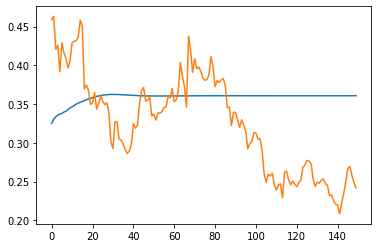

In [19]:
plt.plot(true_predictions)
plt.plot(test)